Looking at the 2m cadence TESS data from sector 31

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
# path = '/media/david/5tb_storage1/cc_cet/tess/MAST_2020-12-21T2128/TESS/tess2020294194027-s0031-0000000337219837-0198-s/'

In [6]:
# lcpath = glob.glob('{}*lc.fits'.format(path))[0]
# lcpath
search_result = lk.search_lightcurve('CC Cet')
search_result


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 31,2020,SPOC,20,337219837,0.0
1,TESS Sector 31,2020,SPOC,120,337219837,0.0
2,TESS Sector 31,2020,TESS-SPOC,600,337219837,0.0


In [ ]:
data = fits.getdata(lcpath,1)
data.names

In [ ]:
t, f, e, q, bk = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY'], data['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]
t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]
#fit = np.polyval((np.polyfit(t,f,2)), t)
#f = (f/fit)-1
#e = (e/fit)
#cut_mask = (bk < 1.1*np.median(bk))
lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_nans()#.remove_outliers(sigma=5)

In [ ]:
lc.plot()

In [ ]:
pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=15*u.day)
#pg.plot()

In [ ]:
plt.plot(pg.period, pg.power)
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0.3, 1)

In [ ]:
lc.fold(pg.period_at_max_power*2).bin(20).errorbar()

In [ ]:
lc1 = lc.normalize(unit='percent')
lc1.flux -=100
lc1.plot()

In [ ]:
pg1 = lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=14*u.day)
plt.plot(pg1.period, pg1.power)
plt.xscale('log')
print(pg1.max_power)

In [ ]:
fitter = fitting.LevMarLSQFitter()


sin_mod =  models.Sine1D(amplitude=pg1.max_power.value, frequency= pg1.frequency_at_max_power.value, phase=0)#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
sin_fit = fitter(sin_mod, lc1.time.value, lc1.flux, weights = 1/lc1.flux_err, maxiter=100000)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc1.time, lc1.flux) 
timefit = np.linspace(lc1.time[0], lc1.time[-1], 2000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
print(sin_fit)
print(sin_fit_e)
print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
print('Phase =', sin_fit.phase.value, sin_fit_e[2])
plt.show()
plt.scatter(lc1.time, lc1.flux-sin_fit(lc1.time))
plt.show()

t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.25)
print(t0)
lcf = lc1.fold(1/sin_fit.frequency.value)
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o')
fold_mod =  models.Sine1D(amplitude=pg1.max_power.value, frequency= 1, phase=0, fixed={'frequency':True})#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
fold_fit = fitter(fold_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
fold_time = np.linspace(-0.5, 0.5, 100)
plt.plot(fold_time, fold_fit(fold_time), c='C1', lw=2, zorder=10)

print('Amplitude =', fold_fit.amplitude.value, fold_fit_e[0])
print('Phase =', fold_fit.phase.value, fold_fit_e[1])
print(fold_fit)
print(fold_fit_e)

Phase error seems like nonsense so estimate it from the %age errors on the other two?

In [ ]:
print(fold_fit_e[0]/abs(fold_fit.amplitude.value))
print(fold_fit_e[1]/fold_fit.frequency.value)
print(1/sin_fit.frequency.value*fold_fit_e[1])

In [ ]:
lc2 = lk.LightCurve(time=lc1.time, flux=lc1.flux-sin_fit(lc1.time), flux_err=lc1.flux_err )
#lc2.flux -= sin_fit(lc1.time)
lc2.plot()

In [ ]:
pg2 = lc2.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
plt.plot(pg2.period, pg2.power)
plt.xscale('log')
print(pg2.period_at_max_power.to(u.min))
print(pg2.max_power)

In [ ]:
lc2.fold(pg2.period_at_max_power).bin(200).errorbar()

In [ ]:
pg1.period_at_max_power/pg2.period_at_max_power

In [ ]:
"""sin_mod2 =  models.Sine1D(amplitude=pg1.max_power.value, frequency= pg1.frequency_at_max_power.value) +models.Sine1D(amplitude=pg2.max_power.value, frequency= pg2.frequency_at_max_power.value)
sin_fit2 = fitter(sin_mod2, lc1.time, lc1.flux, weights = 1/lc1.flux_err)
sin_fit_e2 = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc1.time, lc1.flux) 

plt.plot(timefit, sin_fit2(timefit), c='C1', lw=2) 
print(sin_fit2)
print(sin_fit_e2)
print('Period1 =', (1/sin_fit2[0].frequency.value)*24, (sin_fit_e2[1]/(sin_fit2[1].frequency.value**2))*24, 'h')
print('Amplitude1 =', sin_fit2[0].amplitude.value, sin_fit_e2[0])
print('Period2 =', (1/sin_fit2[1].frequency.value)*24, (sin_fit_e2[4]/(sin_fit2[1].frequency.value**2))*24, 'h')
print('Amplitude2 =', sin_fit2[1].amplitude.value, sin_fit_e2[3])
plt.show()
plt.scatter(lc1.time, lc1.flux-sin_fit2(lc1.time))
plt.show()

#t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.75)
#lcf = lc1.fold(1/sin_fit.frequency.value, t0=t0).bin(50)
#plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o') """

In [ ]:
#FAP

"""n = 10000
#peak_collections = []
check = np.arange(500, n+1, 500)
i = 0
max_peak = []
arr = np.array(lc.flux)
while i < n:
    i+=1
    
    fake_flux = np.random.choice(arr, size=(len(lc1.time)))
    fake_lc = lk.LightCurve(time=lc.time, flux=fake_flux)
    fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
    max_peak.append(max(fake_pg.power).value)
    if i in check:
        print(i)
#peak_collections.append(max_peak)
np.save('fake_peaks2', np.array(max_peak))"""

In [ ]:
# new fap with errors
"""
n = 10000
#peak_collections = []
check = np.arange(500, n+1, 500)
i = 0
max_peak = []
max_peak_e = [] 
arr = np.array(lc.flux)
print(datetime.now().time())
while i < n:
    i+=1
    
    indices = np.random.choice(len(lc1.time), size=(len(lc1.time)))
    fake_lc1 = lk.LightCurve(time=lc1.time, flux=lc1.flux[indices])
    fake_pg1 = fake_lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
    max_peak.append(max(fake_pg1.power).value)
    fake_lc2 = lk.LightCurve(time=lc1.time, flux=lc1.flux[indices], flux_err=lc1.flux_err[indices])
    fake_pg2 = fake_lc2.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
    max_peak_e.append(max(fake_pg2.power).value)
    if i in check:
        print(i)
        print(datetime.now().time())
#peak_collections.append(max_peak)
np.save('fake_peaks3', np.array(max_peak))
np.save('fake_peaks4', np.array(max_peak_e))
print(datetime.now().time())"""

In [ ]:
fake_peaks = np.load('fake_peaks4.npy')
fa99 = np.percentile(fake_peaks, 99.9)
print(fa99)

print(fake_peaks)


In [ ]:
plt.plot(pg1.period, pg1.power)
plt.xscale('log')
plt.axhline(fa99)

So no short period :( make fancy plot. Find ephemeris properly?

In [ ]:
t0 = lc1.time[0] + (1/sin_fit.frequency)*(fold_fit.phase) #0.5 = inferior conjunction
print(t0)
tmid = np.mean(lc1.time)
print(tmid)
tmid2 = lc1.time[0] + (0.5 * (lc1.time[-1] - lc1.time[0]))
print(tmid2)
eph = t0 + np.mean(lc1.time)- lc1.time[0]
print(eph)

plt.plot(timefit, sin_fit(timefit), c='C1', lw=2)
plt.xlim(2156, 2159)
plt.axvline(eph)
#plt.axvline(tmid)
print(sin_fit.phase, sin_fit_e[2])
plt.plot(lc1.time, lc1.flux)

print(eph+2457000)

In [ ]:
lcf = lc1.fold(1/sin_fit.frequency.value, t0=eph).bin(50)
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o')


In [ ]:
#fits.getheader(lcpath, 1)

Final results  
Period = 6.88180 +/- 0.00045 h  
Amplitude = 3.464 +/- 0.039 %  
Ephemeris = 2459157.14821 0.00051   
Nice plot:

In [ ]:
#rule out short periods.

pg1m = pg1.period.to(u.min)
pg1h = pg1.period.to(u.h)
mask = (pg1m > 10*u.min) & (pg1m < 120*u.min)
plt.plot(pg1m[mask], pg1.power[mask])
mean, std = np.mean(pg1.power[mask]).value, np.std(pg1.power[mask]).value
print(np.mean(pg1.power[mask]))
print(np.std(pg1.power[mask]))
plt.axhline(mean+3*std)
plt.show()
plt.hist(pg1.power[mask].value, bins=25)

In [ ]:
b = 5
oc = lc1.bin(b).flux-sin_fit(lc1.bin(b).time)
print(np.mean(oc))
print(np.std(oc))

In [ ]:
# fig,  (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 15))
plt.figure(figsize=(8, 14))
gs = GridSpec(3, 1)
plt.subplot(gs[1, :])
plt.plot(pg1h, pg1.power)
plt.xscale('log')
plt.axhline(fa99, c='C1', ls='--', lw=2)

plt.xlim(pg1h.value[-1], pg1h[0].value)
plt.ylim(0.0001)
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
#axins = inset_axes(ax, width='40%', height='30%', loc=2)
#axins.plot(pg1m[mask], pg1.power[mask])
plt.annotate('P\,=\,{0}\,$\pm$\,{1}\,h \n A\,=\,{2}\,$\pm$\,{3}\,\%'.format(6.88180,0.00045, 3.464,  0.039), (10, 3.), xycoords='data')
plt.annotate('F.A.P. = 1\%', (0.95, fa99+0.1), xycoords=('axes fraction', 'data'), ha='right', va='bottom')

plt.subplot(gs[0, :])


plt.scatter(lc1.time, lc1.flux, s=5, rasterized=True, alpha=0.5) 
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 




plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)

gs1 = gs[2].subgridspec(3, 1, hspace=0)
plt.subplot(gs1[:2, :])
lcf = lc1.fold(1/sin_fit.frequency.value, t0=eph).bin(200)

lcf_mod =  models.Sine1D(amplitude=fold_fit.amplitude, frequency= 1, phase=0, fixed={'amplitude': True, 'frequency':True})
lcf_fit = fitter(lcf_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
#two cycles
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time, lcf_fit(fold_time), c='C1', lw=2, zorder=10)
plt.errorbar(lcf.time+1, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time+1, lcf_fit(fold_time), c='C1', lw=2, zorder=10)

plt.ylabel('Normalised Flux (\%)', size=20)
plt.xticks(visible=False)

xlims = [-0.49, 1.49] #storing here to update both plots at once
plt.xlim(xlims[0], xlims[1])

plt.subplot(gs1[2:, :])
mod = lcf_fit(lcf.time)
plt.errorbar(lcf.time, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.errorbar(lcf.time+1, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.xlim(xlims[0], xlims[1])
plt.ylabel('O-C (\%)', size=20)

plt.xlabel('Phase', size=20)
plt.tight_layout()
#plt.subplots_adjust(hspace=0.18)
# ax.subplots_adjust(hspace=0.7)
#ax1.set_top=0.99
#ax.set_bottom=0.01
#plt.savefig('plots/cc_cet_tess_30s.pdf', dpi=150)

In [ ]:
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(lcf.time, mod)

In [ ]:
np.std(lcf.flux-mod)

No flares? AD test to do a quick check?

In [ ]:
from scipy.stats import anderson
ad = anderson(lc1.flux-sin_fit(lc1.time))
plt.plot(ad.significance_level, ad.critical_values)
plt.axhline(ad.statistic)

Ok AD test failed dramatically? Plot segments in big plot?

In [ ]:
"""chunks = np.arange(0, 27)
tstart = lc1.time[0]
sig = 3
for i in range(len(chunks)-1):
    plt.figure(figsize=(25, 5))
    mask = (lc1.time >= tstart+chunks[i]) & (lc1.time < tstart+chunks[i+1])
    plt.errorbar(lc1.time[mask], lc1.flux[mask]-sin_fit(lc1.time[mask]), lc1.flux_err[mask], marker='o', c='C0', ls='none')
   # mask = (lc1.remove_outliers(sigma=sig).time >= tstart+chunks[i]) & (lc1.remove_outliers(sigma=sig).time < tstart+chunks[i+1])
   # plt.errorbar(lc1.remove_outliers(sigma=sig).time[mask], lc1.remove_outliers(sigma=sig).flux[mask], lc1.remove_outliers(sigma=sig).flux_err[mask], marker='o', c='C0')
    plt.xlim(tstart+chunks[i],tstart+chunks[i+1])
    plt.show()
    if len(lc1.time[mask]) >0:
        ad = anderson(lc1.flux[mask]-sin_fit(lc1.time[mask]))
        if ad.statistic < max(ad.critical_values):
            print('Pass')
        else:
            print('Fail')
    """

In [ ]:
"""flare_can = [2147.3, 2150.3, 2160.2, 2169.6]
for can in flare_can:
    plt.figure(figsize=(5, 5))
    mask = (lc1.time >= can) & (lc1.time < can+0.1)
    plt.errorbar(lc1.time[mask], lc1.flux[mask], lc1.flux_err[mask], marker='o')
   # plt.xlim(tstart+chunks[i],tstart+chunks[i+1])
    plt.show()"""

There's also 20s data available?

In [ ]:
path20 = '/media/david/5tb_storage1/cc_cet/tess/MAST_2021-01-01T1635/TESS/tess2020294194027-s0031-0000000337219837-0198-a_fast/'
lcpath20 = glob.glob('{}*lc.fits'.format(path20))[0]
lcpath20

In [ ]:
data20 = fits.getdata(lcpath20,1)
t, f, e, q, bk = data20['TIME'], data20['PDCSAP_FLUX'], data20['PDCSAP_FLUX_ERR'], data20['QUALITY'], data20['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]
t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]
#fit = np.polyval((np.polyfit(t,f,2)), t)
#f = (f/fit)-1
#e = (e/fit)
#cut_mask = (bk < 1.1*np.median(bk))
lc20 = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_nans()#.remove_outliers(sigma=5)

In [7]:
lc20 = search_result[0].download(download_dir='lightcurves/') 

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


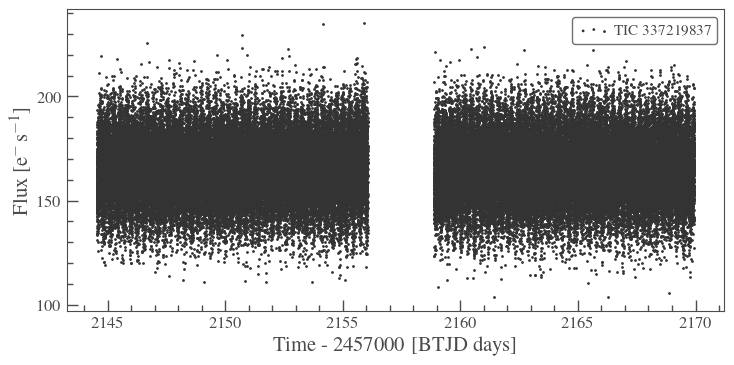

In [8]:
lc20.scatter()

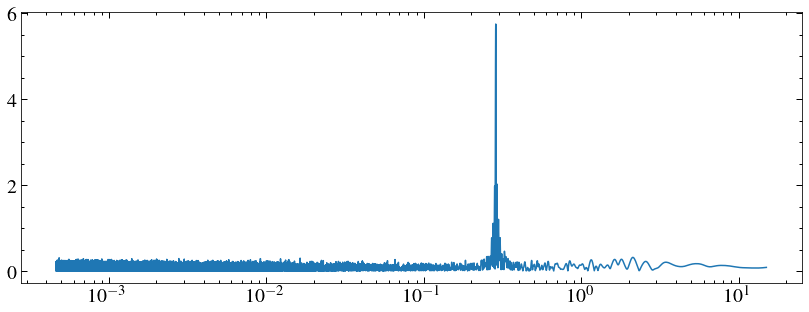

In [9]:
pg20 = lc20.to_periodogram(oversample_factor=10,minimum_period=40*u.second, maximum_period=15*u.day)
plt.plot(pg20.period, pg20.power)
plt.xscale('log')

In [ ]:
plt.errorbar(lc20.time, lc20.flux, yerr=lc20.flux_err, marker='o')
plt.xlim(2145, 2146)

In [ ]:
#lk.search_lightcurvefile('CC Cet')

In [ ]:
lc20n = lc20.normalize(unit='percent')
lc20n.flux -=100
lc20n.plot()

In [ ]:
pg20n = lc20n.to_periodogram(oversample_factor=10,minimum_period=40*u.second, maximum_period=27*u.day)
plt.plot(pg20n.period, pg20n.power)
plt.xscale('log')

In [ ]:


sin_mod =  models.Sine1D(amplitude=pg20n.max_power.value, frequency= pg20n.frequency_at_max_power.value, phase=0)#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
sin_fit = fitter(sin_mod, lc20n.time, lc20n.flux, weights = 1/lc20n.flux_err, maxiter=100000)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.plot(lc20n.time, lc20n.flux) 
timefit = np.linspace(lc20n.time[0], lc20n.time[-1], 2000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
print(sin_fit)
print(sin_fit_e)
print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
print('Phase =', sin_fit.phase.value, sin_fit_e[2])
plt.show()

t0 = t[0] + (1/sin_fit.frequency.value)*(sin_fit.phase-0.25)
print(t0)
lcf = lc20n.fold(1/sin_fit.frequency.value)
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o')
fold_mod =  models.Sine1D(amplitude=pg1.max_power.value, frequency= 1, phase=0, fixed={'frequency':True})#, bounds = dict(amplitude=(0, 1000)))#, bounds={'phase':[0, 1]})
fold_fit = fitter(fold_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
fold_time = np.linspace(-0.5, 0.5, 100)
plt.plot(fold_time, fold_fit(fold_time), c='C1', lw=2, zorder=10)

print('Amplitude =', fold_fit.amplitude.value, fold_fit_e[0])
print('Phase =', fold_fit.phase.value, fold_fit_e[1])
print(fold_fit)
print(fold_fit_e)

20s data shows nothing new.

In [ ]:
# fits.getheader(lcpath, 0)

In [ ]:
# fits.getheader(lcpath20, 0)

Checked if SAP light curve changed the periodogram - No.

In [ ]:
# new fap for 20s with errors
"""
n = 10000
#peak_collections = []
check = np.arange(500, n+1, 500)
i = 0
max_peak = []
# max_peak_e = [] 
print(datetime.now().time())
while i < n:
    i+=1
    
    indices = np.random.choice(len(lc20n.time), size=(len(lc20n.time)))
    fake_lc1 = lk.LightCurve(time=lc20n.time, flux=lc20n.flux[indices])
    fake_pg1 = fake_lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
    max_peak.append(max(fake_pg1.power).value)
   # fake_lc2 = lk.LightCurve(time=lc20n.time, flux=lc20n.flux[indices], flux_err=lc20n.flux_err[indices])
   # fake_pg2 = fake_lc2.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=20*u.day)
   # max_peak_e.append(max(fake_pg2.power).value)
    if i in check:
        print(i)
        print(datetime.now().time())
#peak_collections.append(max_peak)
np.save('fake_peaks5', np.array(max_peak))
#np.save('fake_peaks6', np.array(max_peak_e))
print(datetime.now().time())"""

In [ ]:
fake_peaks = np.load('fake_peaks5.npy')
fa99 = np.percentile(fake_peaks, 99.9)
print(fa99)

# print(fake_peaks)

Oops need to redo down to 30s. Can still redo plot though.

In [ ]:
t0 = lc20n.time[0] + (1/sin_fit.frequency)*(fold_fit.phase) #0.5 = inferior conjunction
print(t0)
tmid = np.mean(lc20n.time)
print(tmid)
tmid2 = lc20n.time[0] + (0.5 * (lc20n.time[-1] - lc20n.time[0]))
print(tmid2)
eph = t0 + np.mean(lc20n.time)- lc20n.time[0]
print(eph)

plt.plot(timefit, sin_fit(timefit), c='C1', lw=2)
plt.xlim(2156, 2159)
plt.axvline(eph)
#plt.axvline(tmid)
print(sin_fit.phase, sin_fit_e[2])
plt.plot(lc20n.time, lc20n.flux)

print(eph+2457000)
print(1/sin_fit.frequency.value*fold_fit_e[1])

In [ ]:
# fig,  (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 15))
plt.figure(figsize=(8, 14))
gs = GridSpec(3, 1)
plt.subplot(gs[1, :])
pg20h = pg20n.period.to(u.hour)
plt.plot(pg20h, pg20n.power)
plt.xscale('log')
plt.axhline(fa99, c='C1', ls='--', lw=2)

plt.xlim(0.05, 14*24)#pg20h[0].value)
plt.ylim(0.0001)
plt.ylabel('Amplitude (\%)', size=20)
plt.xlabel('Period (h)', size=20)
#axins = inset_axes(ax, width='40%', height='30%', loc=2)
#axins.plot(pg1m[mask], pg1.power[mask])
plt.annotate('P\,=\,{0}\,$\pm$\,{1}\,h \n A\,=\,{2}\,$\pm$\,{3}\,\%'.format(6.88233,0.00045, 3.461,  0.039), (0.1, 3.), xycoords='data')
#6.882326693607637 0.0004561525821496103
#-3.4613593519684556 0.039138214912684814

# plt.annotate('0.1\% False Alarm Probability = 0.243\%', (0.95, fa99+0.1), xycoords=('axes fraction', 'data'), ha='right', va='bottom')

plt.subplot(gs[0, :])


plt.scatter(lc20n.time, lc20n.flux, s=5, rasterized=True, alpha=0.1) 
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 




plt.ylabel('Normalised Flux (\%)', size=20)
plt.xlabel('Time (BJD - 2457000)', size=20)
plt.ylim(-39.9, 39.9)

gs1 = gs[2].subgridspec(3, 1, hspace=0)
plt.subplot(gs1[:2, :])
lcf = lc20n.fold(1/sin_fit.frequency.value, t0=eph).bin(1000)

lcf_mod =  models.Sine1D(amplitude=fold_fit.amplitude, frequency= 1, phase=0, fixed={'amplitude': True, 'frequency':True})
lcf_fit = fitter(lcf_mod, lcf.time, lcf.flux, weights = 1/lcf.flux_err, maxiter=100000)
#two cycles
plt.errorbar(lcf.time, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time, lcf_fit(fold_time), c='C1', lw=2, zorder=10)
plt.errorbar(lcf.time+1, lcf.flux, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.plot(fold_time+1, lcf_fit(fold_time), c='C1', lw=2, zorder=10)

plt.ylabel('Normalised Flux (\%)', size=20)
plt.xticks(visible=False)

xlims = [-0.49, 1.49] #storing here to update both plots at once
plt.xlim(xlims[0], xlims[1])

plt.subplot(gs1[2:, :])
mod = lcf_fit(lcf.time)
plt.errorbar(lcf.time, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.errorbar(lcf.time+1, lcf.flux-mod, yerr=lcf.flux_err, ls='none', marker='o', c='C0')
plt.xlim(xlims[0], xlims[1])
plt.ylabel('O-C (\%)', size=20)

plt.xlabel('Phase', size=20)
plt.tight_layout()
#plt.subplots_adjust(hspace=0.18)
# ax.subplots_adjust(hspace=0.7)
#ax1.set_top=0.99
#ax.set_bottom=0.01
plt.savefig('plots/cc_cet_tess_20s.pdf', dpi=150)

Check 20s data for flares

In [ ]:
chunks = np.arange(0, 27)
tstart = lc20n.time[0]
sig = 3
for i in range(len(chunks)-1):
    plt.figure(figsize=(25, 5))
    mask = (lc20n.time >= tstart+chunks[i]) & (lc20n.time < tstart+chunks[i+1])
    plt.errorbar(lc20n.time[mask], lc20.flux[mask]-sin_fit(lc20n.time[mask]), lc20n.flux_err[mask], marker='o', c='C0', ls='none')
   # mask = (lc1.remove_outliers(sigma=sig).time >= tstart+chunks[i]) & (lc1.remove_outliers(sigma=sig).time < tstart+chunks[i+1])
   # plt.errorbar(lc1.remove_outliers(sigma=sig).time[mask], lc1.remove_outliers(sigma=sig).flux[mask], lc1.remove_outliers(sigma=sig).flux_err[mask], marker='o', c='C0')
    plt.xlim(tstart+chunks[i],tstart+chunks[i+1])
    plt.show()
    if len(lc20n.time[mask]) >0:
        ad = anderson(lc20n.flux[mask]-sin_fit(lc20n.time[mask]))
        if ad.statistic < max(ad.critical_values):
            print('Pass')
        else:
            print('Fail')
    

In [ ]:
flare_can = [2147.3, 2150.3, 2160.2, 2169.6]
for can in flare_can:
    plt.figure(figsize=(15, 5))
    mask = (lc20n.time >= can) & (lc20n.time < can+0.1)
    plt.errorbar(lc20n.time[mask], lc20n.flux[mask], lc20n.flux_err[mask], marker='o')
   # plt.xlim(tstart+chunks[i],tstart+chunks[i+1])
    plt.show()